<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. 

# Цель проекта

**Построить модель прогнозирующую количество заказов такси на следующий час.**

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Шаги проекта:

1. Загрузим данные и выполним их ресемплирование по одному часу.
2. Проанализируем данные.
3. Обучим разные модели с различными гиперпараметрами. Сделаем тестовую выборку размером 10% от исходных данных.
4. Проверим данные на тестовой выборке и сделаем выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
!pip install tqdm

In [2]:
import warnings
import time
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit

from sklearn.model_selection import train_test_split
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import make_scorer

from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV

from sklearn import linear_model
import lightgbm as lgb
import lightgbm as lgm

from lightgbm import LGBMRegressor
from IPython.display import display
from catboost import CatBoostRegressor

from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import GridSearchCV, train_test_split, TimeSeriesSplit
from sklearn.linear_model import Ridge
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor

from sklearn.metrics import mean_squared_error
import plotly.graph_objects as go


In [3]:
try:
    try:
    #локальная версия
        df = pd.read_csv('\datasets\taxi.csv', index_col=[0], parse_dates=[0])
    except:    
    #сетевая версия
        df = pd.read_csv('/datasets/taxi.csv', index_col=[0], parse_dates=[0])
except:
    print('Не удалось прочесть файл. Возможно, был указан не верный путь.')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [5]:
df.head(10)

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32
2018-03-01 00:50:00,21
2018-03-01 01:00:00,7
2018-03-01 01:10:00,5
2018-03-01 01:20:00,17


In [6]:
#Проверим, является ли индекс DataFrame (df) монотонным
print(df.index.is_monotonic)

True


In [7]:
df = df.resample('1H').sum()
df.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 4416 entries, 2018-03-01 00:00:00 to 2018-08-31 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  4416 non-null   int64
dtypes: int64(1)
memory usage: 69.0 KB


## Анализ

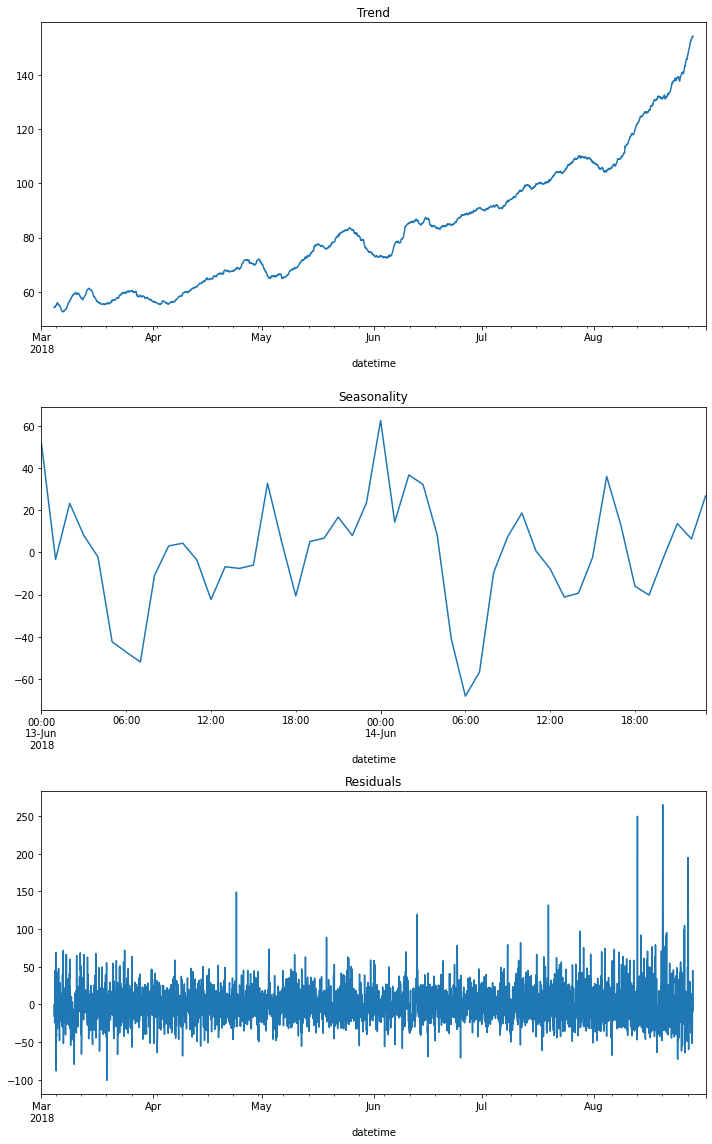

In [9]:
decompose = seasonal_decompose(df, period=24*7)

plt.figure(figsize=(10, 16))
plt.subplot(311)

decompose.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)

decompose.seasonal['2018-06-13':'2018-06-14'].plot(ax=plt.gca())
plt.title('Seasonality')
plt.subplot(313)

decompose.resid.plot(ax=plt.gca())
plt.title('Residuals')

plt.tight_layout()

<AxesSubplot:xlabel='datetime'>

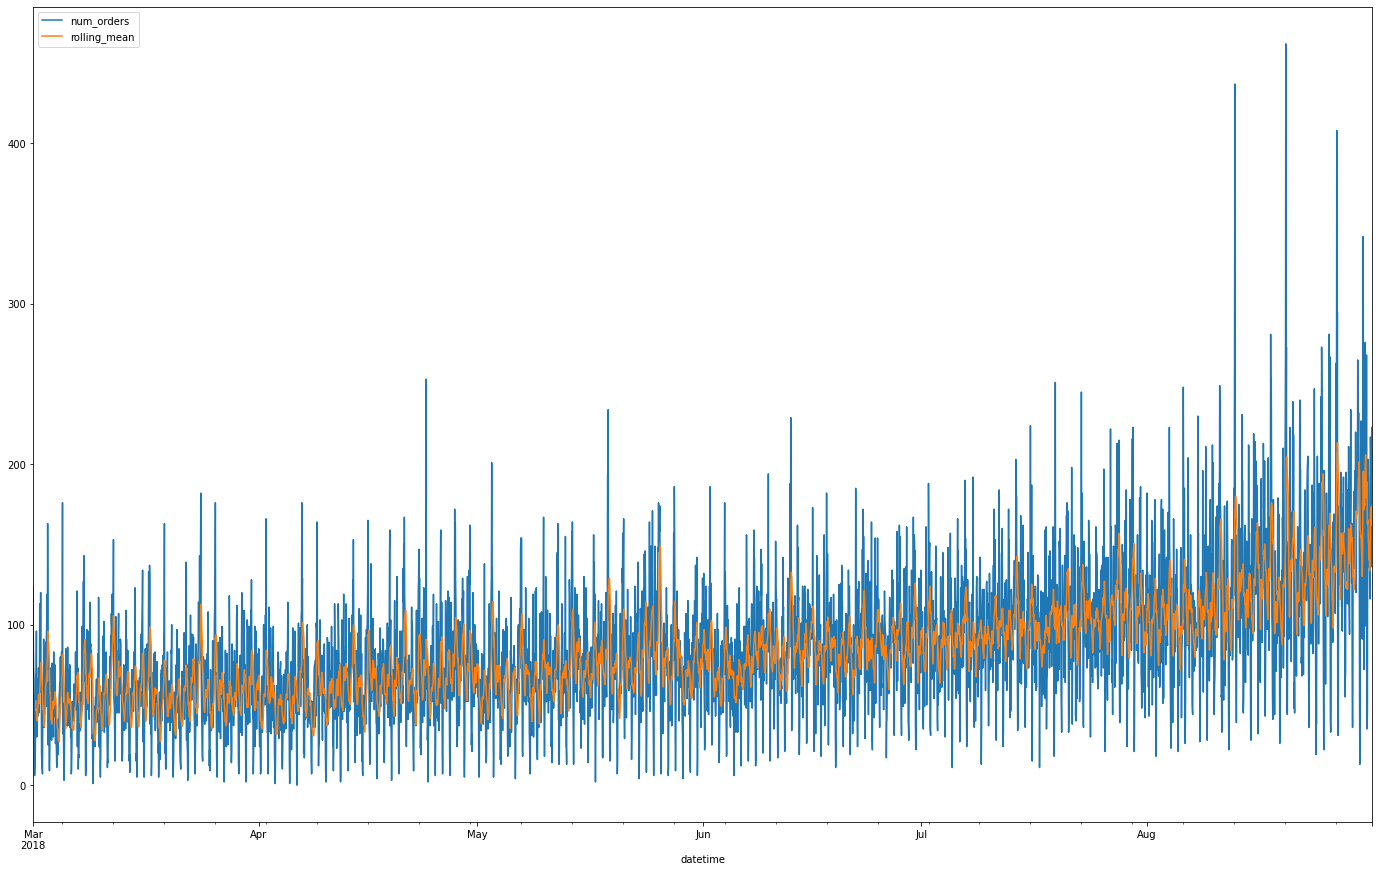

In [10]:
df['rolling_mean'] = df.rolling(10).mean()
df.plot(figsize=(24, 15))

Тренд указывает на увеличение числа заказов, также присутствует высокий спрос на такси в ночное время, потому что в это время не работает общественный транспорт. Можно сказать, что стохастический процесс нестационарный.

## Обучение

In [11]:
def make_features(df, max_lag, rolling_mean_size):
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()

make_features(df, 24, 8)
df.shape

(4416, 30)

In [12]:
df.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-01 00:00:00,124,NaN,2018,3,1,3,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 01:00:00,85,NaN,2018,3,1,3,124.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 02:00:00,71,NaN,2018,3,1,3,85.0,124.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 03:00:00,66,NaN,2018,3,1,3,71.0,85.0,124.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 04:00:00,43,NaN,2018,3,1,3,66.0,71.0,85.0,124.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 05:00:00,6,NaN,2018,3,1,3,43.0,66.0,71.0,85.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 06:00:00,12,NaN,2018,3,1,3,6.0,43.0,66.0,71.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 07:00:00,15,NaN,2018,3,1,3,12.0,6.0,43.0,66.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-03-01 08:00:00,34,52.75,2018,3,1,3,15.0,12.0,6.0,43.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
df = df.dropna()

In [14]:
df.shape

(4392, 30)

In [15]:
df.head(10)

,num_orders,rolling_mean,year,month,day,dayofweek,lag_1,lag_2,lag_3,lag_4,...,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21,lag_22,lag_23,lag_24
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-02 00:00:00,90,62.875,2018,3,2,4,58.0,113.0,66.0,61.0,...,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0,124.0
2018-03-02 01:00:00,120,68.750,2018,3,2,4,90.0,58.0,113.0,66.0,...,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0,85.0
2018-03-02 02:00:00,75,78.250,2018,3,2,4,120.0,90.0,58.0,113.0,...,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0,71.0
2018-03-02 03:00:00,64,78.500,2018,3,2,4,75.0,120.0,90.0,58.0,...,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0,66.0
2018-03-02 04:00:00,20,80.875,2018,3,2,4,64.0,75.0,120.0,90.0,...,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0,43.0
2018-03-02 05:00:00,11,75.750,2018,3,2,4,20.0,64.0,75.0,120.0,...,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0,6.0
2018-03-02 06:00:00,11,68.875,2018,3,2,4,11.0,20.0,64.0,75.0,...,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0,12.0
2018-03-02 07:00:00,7,56.125,2018,3,2,4,11.0,11.0,20.0,64.0,...,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0,15.0
2018-03-02 08:00:00,46,49.750,2018,3,2,4,7.0,11.0,11.0,20.0,...,44.0,43.0,66.0,48.0,32.0,30.0,96.0,64.0,69.0,34.0


In [16]:
train, test = train_test_split(df, shuffle=False, test_size=0.1)

features_train = train.drop('num_orders', axis = 1)
target_train = train['num_orders']

features_test = test.drop('num_orders', axis = 1)
target_test = test['num_orders']

In [17]:
print(train.shape, test.shape)

(3952, 30) (440, 30)


In [18]:
def RMSE(target, predict):
    return (mean_squared_error(target, predict))**0.5
   
#С помощию функции make_scorer создаю метрику RMSE
RMSE_score = make_scorer(RMSE, greater_is_better=False)

In [19]:
results_df = pd.DataFrame(columns=['Model', 'Training Time', 'Prediction Time', 'RMSE Train'])

In [20]:
tscv = TimeSeriesSplit(n_splits=5)

In [21]:
def fit_model(estimator, param_grid, features_train, target_train, features_test, target_test):
    model = GridSearchCV(estimator=estimator,
                         param_grid=param_grid,
                         n_jobs=-1,
                         cv=tscv,
                         scoring='neg_root_mean_squared_error'
                         )

    start_time = time.time()
    model.fit(features_train, target_train)
    training_time = time.time() - start_time

    best_rmse = abs(round(model.best_score_, 1))

    print(f'Best RMSE: {best_rmse}')
    print(f'Best params: {model.best_params_}')

    best_model = estimator.set_params(**model.best_params_)

    start_time = time.time()
    best_model.fit(features_train, target_train)
    prediction_time = time.time() - start_time

    predictions_train = best_model.predict(features_train)
    train_rmse = mean_squared_error(target_train, predictions_train, squared=False)

    return best_model, best_rmse, training_time, prediction_time, train_rmse

In [22]:
best_model, best_rmse, training_time, prediction_time, train_rmse_DTR = \
fit_model(DecisionTreeRegressor(random_state=42), 
          {'max_depth': range(1, 11, 2)}, 
          features_train, target_train, 
          features_test, target_test)

results_df.loc[0] = ['DecisionTreeRegressor', training_time, prediction_time, train_rmse_DTR]

results_df

Best RMSE: 30.1
Best params: {'max_depth': 5}


,Model,Training Time,Prediction Time,RMSE Train
0,DecisionTreeRegressor,0.484812,0.02942,24.970123


In [23]:
best_model, best_rmse, training_time, \
prediction_time, train_rmse_RFR = fit_model(RandomForestRegressor(random_state=42), 
            {'n_estimators': range(50, 100, 10),
             'max_depth': range(1, 11, 2)}, 
            features_train, target_train, features_test, target_test)

results_df.loc[1] = ['RandomForestRegressor', training_time, prediction_time, train_rmse_RFR]

results_df

Best RMSE: 26.0
Best params: {'max_depth': 9, 'n_estimators': 90}


,Model,Training Time,Prediction Time,RMSE Train
0,DecisionTreeRegressor,0.484812,0.02942,24.970123
1,RandomForestRegressor,87.343960,2.92743,16.244613


In [24]:
best_model, best_rmse, training_time, \
prediction_time, train_rmse_LR = fit_model(LinearRegression(), 
            [{'fit_intercept': [True, False]},
             {'copy_X': [True, False]}, {'n_jobs': [1, -1]}], 
            features_train, target_train, features_test, target_test)

results_df.loc[2] = ['LinearRegression', training_time, prediction_time, train_rmse_LR]

results_df

Best RMSE: 27.0
Best params: {'fit_intercept': False}


,Model,Training Time,Prediction Time,RMSE Train
0,DecisionTreeRegressor,0.484812,0.029420,24.970123
1,RandomForestRegressor,87.343960,2.927430,16.244613
2,LinearRegression,2.843956,0.093038,25.824713


In [25]:
best_model, best_rmse, training_time, \
prediction_time, train_rmse_LR = fit_model(CatBoostRegressor(random_state=42, verbose=False), 
            {'depth': [4, 6, 8], 'learning_rate': [0.01, 0.1, 1]}, 
            features_train, target_train, features_test, target_test)

results_df.loc[3] = ['CatBoostRegressor', training_time, prediction_time, train_rmse_LR]

results_df

Best RMSE: 24.9
Best params: {'depth': 8, 'learning_rate': 0.1}


,Model,Training Time,Prediction Time,RMSE Train
0,DecisionTreeRegressor,0.484812,0.029420,24.970123
1,RandomForestRegressor,87.343960,2.927430,16.244613
2,LinearRegression,2.843956,0.093038,25.824713
3,CatBoostRegressor,385.477457,21.981830,2.568139


In [26]:
model = LGBMRegressor(random_state=42)

# Определяем сетку гиперпараметров для настройки
parameters = {'n_estimators': [50, 100, 20],
              'max_depth': [3, 8, 2]}

# Выполняем поиск по сетке с использованием перекрестной проверки
best_model, best_rmse, training_time_LGBM, \
prediction_time_LGBM, train_rmse_LGBM = fit_model(model, 
                                                  parameters, 
                                                  features_train, 
                                                  target_train, 
                                                  features_test, 
                                                  target_test)

# Добавляем результаты текущей модели в фреймворк данных
results_df.loc[4] = ['LGBMRegressor', training_time_LGBM, prediction_time_LGBM, train_rmse_LGBM]

# Показываем результаты
results_df

Best RMSE: 25.6
Best params: {'max_depth': 3, 'n_estimators': 100}


,Model,Training Time,Prediction Time,RMSE Train
0,DecisionTreeRegressor,0.484812,0.029420,24.970123
1,RandomForestRegressor,87.343960,2.927430,16.244613
2,LinearRegression,2.843956,0.093038,25.824713
3,CatBoostRegressor,385.477457,21.981830,2.568139
4,LGBMRegressor,257.514256,11.501029,20.913676


<p>Мы провели разбивку на тренировочную(10% от данных). Функция fit_model(), использует метод GridSearchCV для подбора наилучшей модели и вывода метрики RMSE и параметров лучшей модели. Обучено 5 моделей
    - <code>DecisionTreeRegressor</code>, <code>RandomForestRegressor</code>, <code>LinearRegression</code>, <code>CatBoostRegressor</code>, <code>LGBMRegressor</code>). Лучшую RMSE показала <code>CatBoostRegressor</code>, проверим её предсказания на тестовых данных.</p>

## Тестирование

In [29]:
def display_result(target, pred, rmse, model_name):
    
    # Преобразуем целевую переменную в DataFrame и сбрасываем индекс
    result = target.to_frame().reset_index()
    
    # Добавляем столбец с предсказаниями в DataFrame
    result['prediction'] = pd.Series(pred)
    
    # Устанавливаем столбец datetime в качестве индекса
    result.set_index('datetime', inplace=True)
    fig = go.Figure()
    
    # Добавляем график с реальными значениями
    fig.add_trace(go.Scatter(x=result.index, y=result[target.name], name='True'))
    
     # Добавляем график с предсказанными значениями
    fig.add_trace(go.Scatter(x=result.index, y=result['prediction'], name='Predicted'))
    
    # Устанавливаем заголовок графика и подписи осей
    fig.update_layout(title=model_name + ' (RMSE: ' + str(rmse) + ')', \
                      xaxis_title='Время (дни)', yaxis_title='Количество заказов', plot_bgcolor='white')
    
    # Отображаем график
    display(fig)

In [30]:
for i in range(len(results_df)):
    model_name = results_df.loc[i, 'Model']
    
    if model_name == 'CatBoostRegressor':
        model = CatBoostRegressor(verbose=False)
        
        # Подгоняем модель к обучающим данным
        model.fit(features_train, target_train)
        
        # Спрогнозируем на тестовых данных
        predictions = model.predict(features_test)
        
        # Рассчитаем среднеквадратичное отклонение
        rmse = mean_squared_error(target_test, predictions, squared=False)
        
        # Выводим результаты
        display_result(target_test, predictions, rmse, model_name)

# Итоговый вывод

Мы создали и обучили модели машинного обучения для прогнозирования количества заказов такси в аэропортах на следующий час. 
Результаты на тестовой выборке показали, что лучшей моделью для успешного прогнозирования является CatBoostRegressor с RMSE 40.11. Цель проекта достигнута.

## Чек-лист проверки

- [x]  Jupyter Notebook открыт
- [x]  Весь код выполняется без ошибок
- [x]  Ячейки с кодом расположены в порядке исполнения
- [x]  Данные загружены и подготовлены
- [x]  Данные проанализированы
- [x]  Модель обучена, гиперпараметры подобраны
- [x]  Качество моделей проверено, выводы сделаны
- [x]  Значение *RMSE* на тестовой выборке не больше 48